In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Data Preprocessing

In [67]:
# Load Well 1 data
well1_data = pd.read_excel('Volve.xlsx', sheet_name='well 1')

# Logarithmic Transformation of GR and RT
well1_data['RT_log'] = np.log10(well1_data['RT'])
well1_data['GR_log'] = np.log10(well1_data['GR'])

In [68]:
# Drop 'Well' column as it's not useful
well1_data.drop('Well', axis=1, inplace=True)

# Check for missing values
if well1_data.isnull().any().any() or well1_data.isna().any().any():
    print("There are missing values in the data.")

In [69]:
well1_data.head()

,Depth,GR,RT,RHOB,NPHI,RT_log,GR_log
0,4175.5,20.6032,4.1812,2.6117,0.0770,0.621301,1.313935
1,4176.0,21.4990,4.5516,2.6131,0.0798,0.658164,1.332418
2,4176.5,22.4472,4.4804,2.6334,0.0801,0.651317,1.351162
3,4177.0,29.6713,4.3859,2.6328,0.1005,0.642059,1.472337
4,4177.5,34.7014,4.8566,2.6183,0.1001,0.686332,1.540347


In [70]:
well1_data['Magnitude_GR_RT'] = np.sqrt(well1_data['GR']**2 + well1_data['RT']**2)
well1_data['Angle_GR_RT'] = np.arctan2(well1_data['RT'], well1_data['GR'])

In [71]:
well1_data.drop(['RT','GR'], inplace = True,axis = 1) # drop the original RT and GR

In [72]:
well1_data.head()

,Depth,RHOB,NPHI,RT_log,GR_log,Magnitude_GR_RT,Angle_GR_RT
0,4175.5,2.6117,0.0770,0.621301,1.313935,21.023184,0.200220
1,4176.0,2.6131,0.0798,0.658164,1.332418,21.975533,0.208631
2,4176.5,2.6334,0.0801,0.651317,1.351162,22.889971,0.197008
3,4177.0,2.6328,0.1005,0.642059,1.472337,29.993702,0.146754
4,4177.5,2.6183,0.1001,0.686332,1.540347,35.039602,0.139051


In [73]:
well1_data.shape

(827, 7)

In [74]:
from sklearn.ensemble import IsolationForest

iforest = pickle.load(open('outlier.sav', 'rb'))

label = iforest.predict(well1_data)

data_i_x = well1_data[label == 1]

In [75]:
data_i_x.shape

(785, 7)

In [76]:
from sklearn.preprocessing import StandardScaler
ss = pickle.load(open('scale.sav', 'rb'))
data_i_s = ss.fit_transform(well1_data)
df_scaled = pd.DataFrame(data_i_s, columns=well1_data.columns, index=well1_data.index)

In [77]:
df_scaled.head()

,Depth,RHOB,NPHI,RT_log,GR_log,Magnitude_GR_RT,Angle_GR_RT
0,-1.729958,1.008883,-1.255419,0.854972,-2.054739,-1.083616,0.570038
1,-1.725769,1.020284,-1.220298,0.940306,-1.950643,-1.052268,0.613112
2,-1.721580,1.185606,-1.216535,0.924455,-1.845081,-1.022169,0.553590
3,-1.717391,1.180719,-0.960649,0.903024,-1.162648,-0.788346,0.296238
4,-1.713203,1.062633,-0.965666,1.005512,-0.779626,-0.622257,0.256792


In [78]:
F = pickle.load(open('Deploy_F_Values.sav', 'rb'))
mi = pickle.load(open('Deploy_mi_Values.sav', 'rb'))
mask = (F>300)|(mi>0.36)

In [79]:
x_assoc = df_scaled.iloc[:, mask]
print('X post f and mi filter= ', x_assoc.shape)

X post f and mi filter=  (827, 6)


In [80]:
from sklearn.preprocessing import QuantileTransformer

qt = pickle.load(open('Deploy_QT.sav', 'rb'))

x_assoc_transformed = qt.fit_transform(x_assoc)

In [81]:
# Checking the shape and perhaps the first few rows to verify everything went as expected
print("Transformed features shape:", x_assoc_transformed.shape)

#Convert back to a DataFrame for further use with column names
x_assoc_transformed_df = pd.DataFrame(x_assoc_transformed, columns=x_assoc.columns, index=x_assoc.index)
x_assoc_transformed_df.head()

Transformed features shape: (827, 6)


,Depth,RHOB,NPHI,GR_log,Magnitude_GR_RT,Angle_GR_RT
0,0.000000,0.858165,0.026096,0.028323,0.015153,0.906037
1,0.001211,0.861887,0.031867,0.031458,0.018195,0.911439
2,0.002421,0.926504,0.032674,0.037172,0.021647,0.903121
3,0.003632,0.924032,0.089345,0.093443,0.071129,0.868157
4,0.004843,0.878863,0.088270,0.176691,0.162591,0.862850


In [82]:
kmeans = pickle.load(open('Deploy_Kmeans_Labels.sav', 'rb'))
# Apply Mean Shift with the estimated bandwidth
mean_shift = pickle.load(open('Deploy_Meanshift_Labels.sav', 'rb'))

# Apply clustering model to generate labels for testing data
test_kmeans_labels = kmeans.predict(x_assoc_transformed_df)
test_meanshift_labels = mean_shift.predict(x_assoc_transformed_df)

x_assoc_transformed_df['cluster_kmeans'] = test_kmeans_labels
x_assoc_transformed_df['cluster_meanshift'] = test_meanshift_labels

In [83]:
x_assoc_transformed_df.head()

,Depth,RHOB,NPHI,GR_log,Magnitude_GR_RT,Angle_GR_RT,cluster_kmeans,cluster_meanshift
0,0.000000,0.858165,0.026096,0.028323,0.015153,0.906037,3,1
1,0.001211,0.861887,0.031867,0.031458,0.018195,0.911439,3,1
2,0.002421,0.926504,0.032674,0.037172,0.021647,0.903121,3,1
3,0.003632,0.924032,0.089345,0.093443,0.071129,0.868157,3,1
4,0.004843,0.878863,0.088270,0.176691,0.162591,0.862850,3,1


In [84]:
x_assoc_transformed_df.shape

(827, 8)

## Deployment

In [85]:
rfr_best_model = pickle.load(open('Deploy_Random_Forest_Model_best.sav', 'rb'))
gb_second_best_model = pickle.load(open('Deploy_Gradient_Boosting_Model_secondbest.sav', 'rb'))
nn_third_best_model = pickle.load(open('Deploy_Neural_Network_Model_thirdbest.sav', 'rb'))

In [86]:
x_assoc_transformed_df.head()

,Depth,RHOB,NPHI,GR_log,Magnitude_GR_RT,Angle_GR_RT,cluster_kmeans,cluster_meanshift
0,0.000000,0.858165,0.026096,0.028323,0.015153,0.906037,3,1
1,0.001211,0.861887,0.031867,0.031458,0.018195,0.911439,3,1
2,0.002421,0.926504,0.032674,0.037172,0.021647,0.903121,3,1
3,0.003632,0.924032,0.089345,0.093443,0.071129,0.868157,3,1
4,0.004843,0.878863,0.088270,0.176691,0.162591,0.862850,3,1


In [87]:
# Predictions
predictions_rfr = rfr_best_model.predict(x_assoc_transformed_df)
predictions_gb = gb_second_best_model.predict(x_assoc_transformed_df)
predictions_nn = nn_third_best_model.predict(x_assoc_transformed_df)

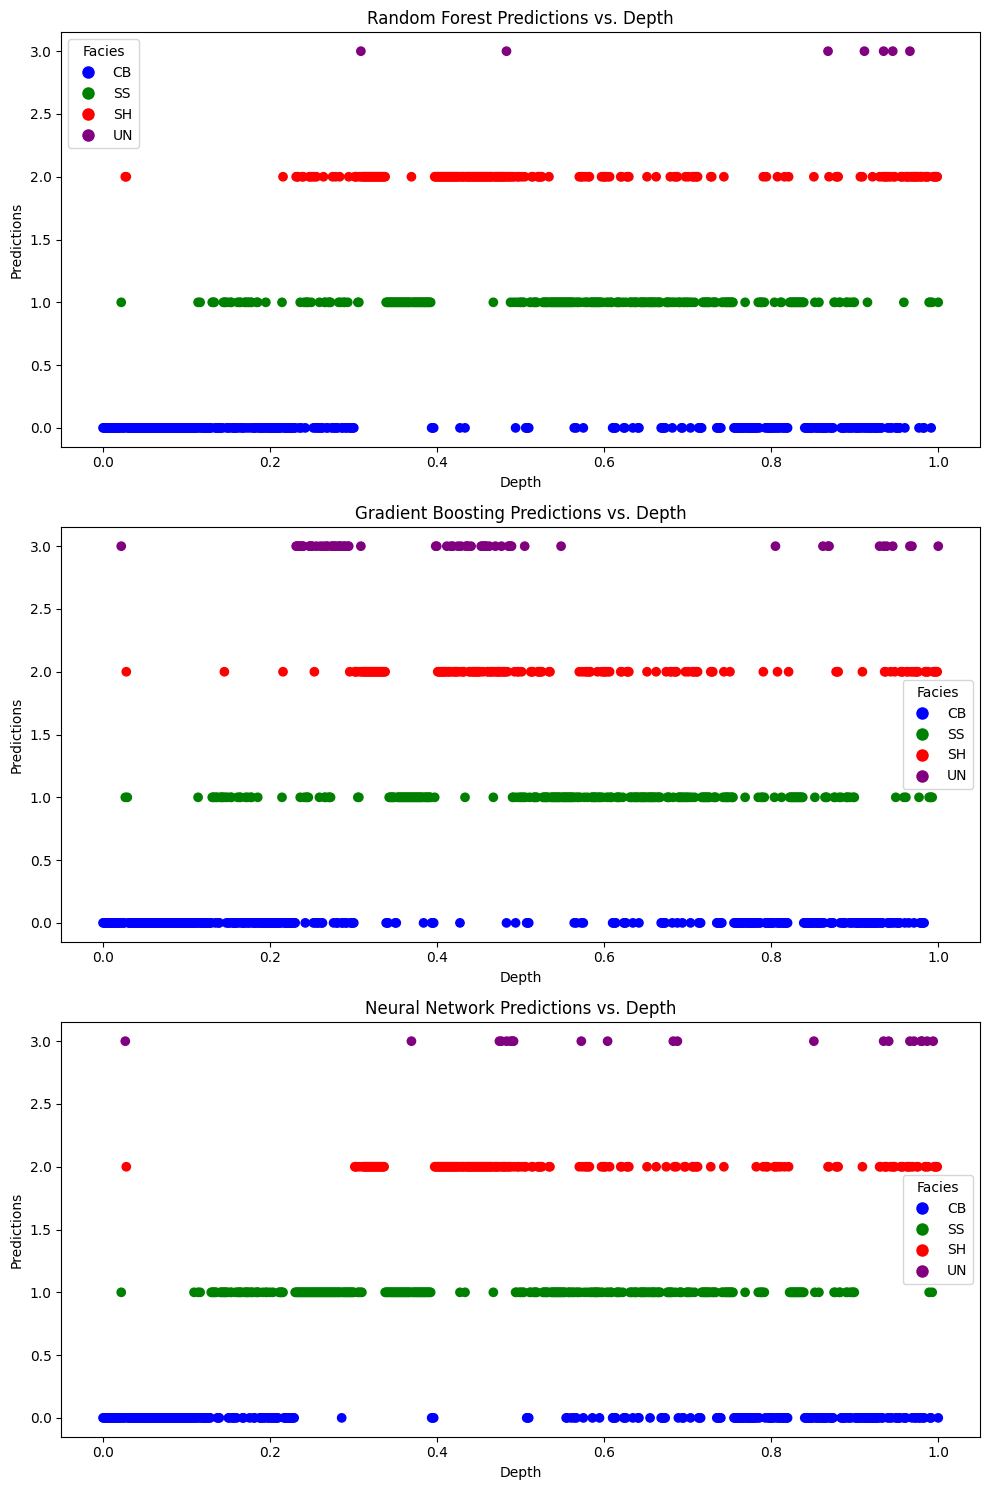

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Define categories and their mappings
categories = {'CB': 0, 'SS': 1, 'SH': 2, 'UN': 3}
category_colors = np.array(['blue', 'green', 'red', 'purple'])  # Assign colors

# Prepare numeric predictions for plotting
predictions_rfr_numeric = [categories[pred] for pred in predictions_rfr]
predictions_gb_numeric = [categories[pred] for pred in predictions_gb]
predictions_nn_numeric = [categories[pred] for pred in predictions_nn]

# Create a figure with subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot each set of predictions
for i, (predictions, title) in enumerate(zip([predictions_rfr_numeric, predictions_gb_numeric, predictions_nn_numeric], ['Random Forest', 'Gradient Boosting', 'Neural Network'])):
    scatter = ax[i].scatter(x_assoc_transformed_df['Depth'], predictions, c=category_colors[predictions], label=f'{title} Predictions')
    ax[i].set_title(f'{title} Predictions vs. Depth')
    ax[i].set_xlabel('Depth')
    ax[i].set_ylabel('Predictions')

    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=facies,
                              markerfacecolor=color, markersize=10) for facies, color in zip(categories, category_colors)]
    ax[i].legend(handles=legend_elements, title="Facies")

plt.tight_layout()
plt.show()

## Export the predictions of the 3 top-performing models for Well 1 along with depth and GR log to a separate XLS file (Prediction.xlsx)

In [89]:
import pandas as pd

# 'predictions_rfr', 'predictions_gb', and 'predictions_nn' are model predictions for Well 1
# and 'x_assoc_transformed_df' is DataFrame that includes 'Depth' and 'GR_log'

# Add model predictions to the DataFrame
x_assoc_transformed_df['Predictions_RF'] = predictions_rfr
x_assoc_transformed_df['Predictions_GB'] = predictions_gb
x_assoc_transformed_df['Predictions_NN'] = predictions_nn

# Select the necessary columns to export
export_columns = ['Depth', 'GR_log', 'Predictions_RF', 'Predictions_GB', 'Predictions_NN']
export_df = x_assoc_transformed_df[export_columns]
export_df['GR'] = 10 ** export_df['GR_log']

/var/folders/tt/nhzdgbqx6z1_g0ltcwqr_nsh0000gn/T/ipykernel_6320/4191995695.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['GR'] = 10 ** export_df['GR_log']


In [90]:
# Make sure to install openpyxl if not already installed:
# pip install openpyxl

# Export DataFrame to Excel
export_df.to_excel('Prediction.xlsx', index=False, engine='openpyxl')